In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/AMOD/dt-object-detection")  #change folder name accordingly
print(os.getcwd())
print(os.listdir())

with open("./test.txt", "w") as f:  # verify that you did get a new file in your Drive
  f.write("Hello, world!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/AMOD/dt-object-detection
['clone.sh', 'Dockerfile', '.gitignore', 'requirements.txt', '.git', 'eval', '.vscode', 'data_collection', 'src', 'model', 'test.txt', 'Network test.gsheet']


In [2]:
import sys
paths = [os.path.join(os.getcwd(), 'model'), os.path.join(os.getcwd(), 'eval')]
for p in paths:
  if p not in sys.path:
    sys.path.insert(1, p)
from importlib import reload

In [9]:
import train
train = reload(train)
# train_path = os.path.join(os.getcwd(), 'data_collection', 'dataset', 'train_dataset')
train_path = os.path.join(os.getcwd(), 'data_collection', 'dataset', 'train_dataset_large')
model_path = os.path.join(os.getcwd(), 'model', 'weights')
train.main(train_path, model_path, 1, 2)

batch size = 2
Initialized fasterrcnn_resnet_100_5_layers.


RuntimeError: ignored

In [7]:
import os
import model
model = reload(model)
model_path = os.path.join(os.getcwd(), 'model', 'weights')
model_filepath = os.path.join(model_path, 'model.pth')
from google.colab.patches import cv2_imshow
import numpy as np
import utils
utils = reload(utils)
import cv2
from map_sol import mean_average_precision
from torchvision.transforms.functional import to_tensor

from tqdm import trange

def test_dataset(test_path, index=None, display_every=10):
    dataset_files = list(filter(lambda x: "npz" in x, os.listdir(test_path)))

    true_boxes = []
    pred_boxes = []

    def make_boxes(id, labels, scores, bboxes):
        temp = []
        for i in range(len(labels)):
            x1 = bboxes[i][0]
            y1 = bboxes[i][1]
            x2 = bboxes[i][2] - x1
            y2 = bboxes[i][3] - y1

            temp.append([id, labels[i], scores[i], x1, y1, x2, y2])
        return temp

    wrapper = model.Wrapper()

    BATCH_SIZE = 4
    BATCH_QTTY = int(len(dataset_files) / BATCH_SIZE)

    def make_batches(list):
        for i in range(0, len(list), BATCH_SIZE):
            yield list[i:i+BATCH_SIZE]

    batches = list(make_batches(dataset_files[:BATCH_QTTY*BATCH_SIZE]))

    if index is not None:
      batches = batches[0:index]

    images_ann = []

    img_ind = 0
    for nb_batch in trange(len(batches)):
        batch = batches[nb_batch]

        for nb_img, file in enumerate(batch):
            with np.load(os.path.join(test_path, file)) as data:
                img, boxes, classes = tuple([data[f"arr_{i}"] for i in range(3)])
                p_boxes, p_classes, p_scores = wrapper.predict(np.array([img]))

                for j in range(len(p_boxes)):
                    pred_boxes += make_boxes(nb_batch+nb_img, p_classes[j], p_scores[j], p_boxes[j])
                true_boxes += make_boxes(nb_batch+nb_img, classes, [1.0]*len(classes), boxes)
                
                if img_ind % display_every == 0:
                    curr_img = utils.img_boxes(img, p_boxes[0], p_classes[0], True, (255,0,0))
                    curr_img = utils.img_boxes(curr_img, boxes, classes, True, (0,0,255))
                    images_ann.append(curr_img)
                img_ind += 1




    true_boxes = np.array(true_boxes, dtype=float)
    pred_boxes = np.array(pred_boxes, dtype=float)
    # print(mean_average_precision(pred_boxes, true_boxes, box_format="midpoint", num_classes=5))
    print(mean_average_precision(pred_boxes, true_boxes, box_format="midpoint", num_classes=5).item())
    # approx 87%!!!

    for img in images_ann:
        cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

NEWSTYLE VALIDATION SET


100%|██████████| 12/12 [00:29<00:00,  2.45s/it]


0.7513213753700256


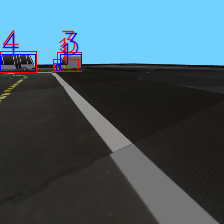

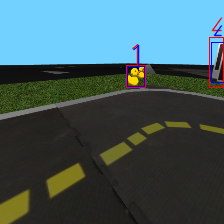

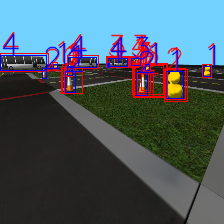

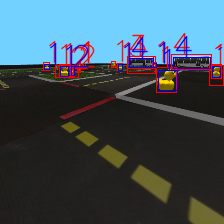

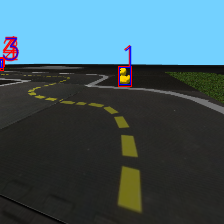

In [8]:
ns_val = os.path.join(os.getcwd(), 'data_collection', 'dataset', 'newstyle_validation_dataset')
val_path = os.path.join(os.getcwd(), 'data_collection', 'dataset', 'validation_dataset')

print('NEWSTYLE VALIDATION SET')
test_dataset(ns_val)

# print('VALIDATION DATASET')
# test_dataset(val_path, 100, 20)